This Jupyter Notebook contains all of image preparation, excluding the creation of HSV color Models. 



Author: David Schroth
Last Change: 2025-06-27

#  1. Overview and Preparation
We want to apply Filters to our images and see if different applied filters have an influence on  the success of our clustering




### 1.1 Import Libraries

In [57]:
# Import Required Libraries
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from skimage import io, color, morphology, segmentation, filters
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import os 
from matplotlib import colors 






### 1.2 Import Custom Functions for Data Preparation

In [58]:
# Import custom functions
from Functions.Datenvorbereitung import apply_gaussian_filter 
from Functions.Datenvorbereitung import display_images
from Functions.Datenvorbereitung import save_image
from Functions.Datenvorbereitung import apply_bilateral_filter
from Functions.Datenvorbereitung import split_channels
from Functions.Datenvorbereitung import remove_channel
from Functions.Datenvorbereitung import norm_255
from Functions.Datenvorbereitung import z_normalize
from Functions.Datenvorbereitung import apply_gaussian_to_array
from Functions.Datenvorbereitung import save_as_numpy
from Functions.Datenvorbereitung import apply_median_filter
from Functions.Datenvorbereitung import display_images_grey
from Functions.Datenvorbereitung import apply_bilateral_to_array
from Functions.Datenvorbereitung import save_image_grey
from Functions.Datenvorbereitung import apply_gauß_to_string
from Functions.Datenvorbereitung import apply_bilateral_to_string
from Functions.Datenvorbereitung import remove_alpha_channel
from Functions.Datenvorbereitung import apply_watershed
from Functions.Datenvorbereitung import save_raw_image

from Functions.FinalKMeans import kmeans



### 1.3 Load Original Images


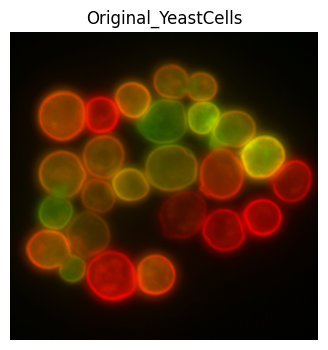

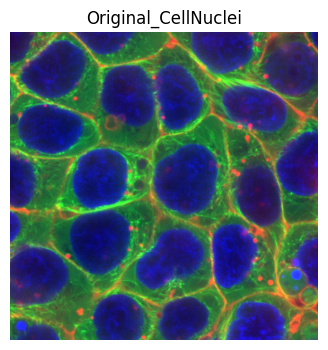

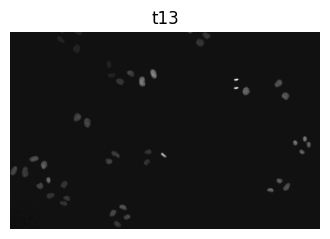

In [59]:
YeastCells = np.copy(plt.imread('Original_Images/Clustering/Data/Yeast_Cells.jpg'))

CellNuclei = np.copy(plt.imread('Original_Images/Clustering/Data/Cell_Nuclei.tiff'))

# Load Example Image from Otsu Dataset
t13 = cv2.imread('Original_Images/Otsu/Data/N2DL-HeLa/img/t13.tif', cv2.IMREAD_GRAYSCALE)


display_images(YeastCells, "Original_YeastCells")
display_images(CellNuclei, "Original_CellNuclei")

display_images_grey(t13, "t13")



# 2. Image Filtering
We want to apply Filters to our images and see if different applied filters have an influence on  the success of our clustering.  
We are using different filters and approaches for each kind of image depending on our goal. There is no guarantee that the aapporoch is the best/correct for the image since its our first time doing this.  
Our goal here is to showcase different filters, whats their influence on our image and how they work.  
In the evaluation and final presentation we will discuss how good each approach was.
More details about our thoughts and why we use the filters were thouroughly discussed in the project proposal.

### Fluorecent Yeast Cells
One thing we want to try on the fluorescent yeast cell image is to reduce the halos around the cells using different filters.  
We will perform k-means clustering after application of the filters and the original image, then conclude the dice score to see ife filters influende the clustering process.

## 2.1 Gauß Filter

A **Gaussian filter** is used to blur (smooth) an image by reducing noise and detail. It works by ittrereting over every pixel a small matrix (kernel) whose values follow a 2D Gaussian (bell-curve) distribution:

- **Kernel shape**: A square grid (e.g. 3×3, 5×5) where the center has the highest weight and the weights fall off towards the edges.
- **Convolution**: For each pixel, multiply the surrounding pixels by the corresponding kernel weights and sum them up. This replaces the original pixel with a weighted average of its neighborhood.
- **σ (sigma)**: Controls the “spread” of the bell curve. A larger σ produces stronger blurring (more smoothing), while a smaller σ keeps more detail.
- **Benefits**:  
  - Smooths away high-frequency noise  
  - Preserves overall image structure  
  - Often used as a preprocessing step for edge detection or image enhancement

Mathematically, the 2D Gaussian kernel is defined as:

$$
G(x, y) = \frac{1}{2 \pi \sigma^2} \exp\!\Bigl(-\frac{x^2 + y^2}{2 \sigma^2}\Bigr)
$$

where \(x\) and \(y\) are the horizontal and vertical distances from the kernel center.

### 2.1.1 Apply Gauß-Filter to arbitrary Image



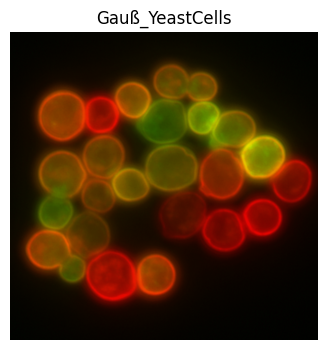

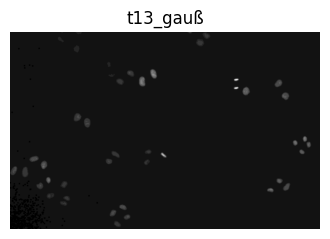

t13_gauß_norm: [[0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 [0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 [0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 ...
 [0.5019608 0.5019608 0.5019608 ... 0.5058824 0.5058824 0.5058824]
 [0.5019608 0.5019608 0.5019608 ... 0.5058824 0.5058824 0.5058824]
 [0.5019608 0.5019608 0.5019608 ... 0.5058824 0.5058824 0.5058824]]


In [60]:

#########################################
input_path = "Original_Images/Clustering/Data/Yeast_Cells.jpg"  
kernel_size = 5
#########################################
#------------------------------------------------------------------------------
# 1. Apply Gaussian Filter to Yeast Cells Image

gauß_yeastcells = apply_gaussian_filter(input_path, kernel_size)
  

display_images(gauß_yeastcells, "Gauß_YeastCells")
#------------------------------------------------------------------------------

# 2. apply Gaussian Filter to t13 Image
t13_gauß = apply_gaussian_to_array(t13, kernel_size)

display_images_grey(t13_gauß, "t13_gauß")

# 3. Normalisiere t13_gauß
t13_gauß_norm = t13_gauß.astype(np.float32) / 255.0

print("t13_gauß_norm:", t13_gauß_norm)

# save_image_grey(t13_gauß_norm, "t13_gauß_norm", ext="tiff")




### 2.1.2 Safe gauß filtered image to downloads

With this function we can safe our filtered images (or other images) to our local "downloads" folder

In [61]:
# save_image(gauß_image, "Gauß_YeastCells", ext= "jpeg")
# save_image_grey(t13_gauß, "t13_gauß", ext= "tiff")

## 2.2 Bilateral Filter

A **bilateral filter** smooths an image while keeping edges sharp by combining two ideas:

1. **Distance weight**: pixels closer to the center count more.  
2. **Color weight**: pixels with similar color count more.








Both weights are Gaussian functions:




- **Kernel size**: $$(2K+1) \times (2K+1)$$  
- $\sigma_s$ (spatial sigma): controls how far the smoothing extends  
- $\sigma_r$ (range sigma): controls how much color difference is tolerated

**Why use it?**  
- Removes noise in flat regions  
- Keeps edges and small details
- Great preprocessing for segmentation or feature extraction


### 2.2.1 Apply Bilateral Filter to arbitrary Image

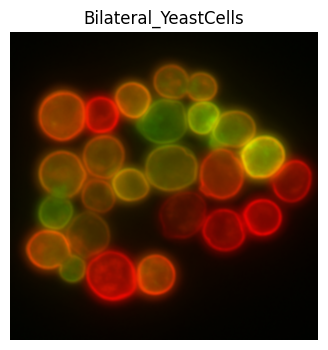

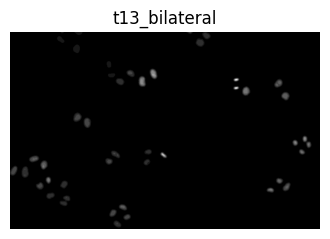

t13_bilateral_norm: [[0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 [0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 [0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 ...
 [0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 [0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]
 [0.5058824 0.5058824 0.5058824 ... 0.5058824 0.5058824 0.5058824]]


In [62]:
input_path   = "Original_Images/Clustering/Data/Yeast_Cells.jpg"
kernel_size  = 9

# apply_bilateral_filter liefert ein Tuple, genau wie apply_gaussian_filter
bilateral_YeastCells  = apply_bilateral_filter(input_path, kernel_size)


# Anzeige
display_images(bilateral_YeastCells, "Bilateral_YeastCells")

#################################################################

t13_bilateral = apply_bilateral_to_array(t13, kernel_size)

display_images_grey(t13_bilateral, "t13_bilateral")


t13_bilateral_norm = t13_bilateral.astype(np.float32) / 255.0

print("t13_bilateral_norm:", t13_bilateral_norm)

# save_image_grey(t13_bilateral_norm, "t13_bilateral_norm", ext="tiff")

### 2.2.2 Safe bilateral filtered image to downloads

In [63]:
# save_image(bilateral_image, "Bilateral_YeastCells", ext= "jpeg")
# save_image_grey(t13_bilateral, "t13_bilateral", ext= "tiff")

## 2.3 Median Filter 
### 2.3.1 Apply Median Filter to HSV
We do apply a Medium Filter zu the HSV Image to reduce the unwanted black, kind of "salt and pepper" dots

HSV Image Array
[[[0.11764706 1.         0.00784314 1.        ]
  [0.11764706 1.         0.00784314 1.        ]
  [0.02352941 1.         0.01960784 1.        ]
  ...
  [0.23529412 1.         0.01568628 1.        ]
  [0.23529412 1.         0.00784314 1.        ]
  [0.1764706  1.         0.00784314 1.        ]]]
HSV Image Array as uint8
[[[ 30 255   2 255]
  [ 30 255   2 255]
  [  6 255   5 255]
  ...
  [ 60 255   4 255]
  [ 60 255   2 255]
  [ 45 255   2 255]]]


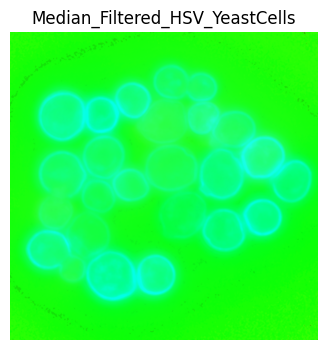

In [64]:
HSV_Image = np.copy(plt.imread('Images/Datenvorbereitung_Images/YeastCells/HSV_Yeast/HSV_YeastCells.png'))
print("HSV Image Array")
print(HSV_Image[:1])


# Convert to uint8 for OpenCV median filter
HSV_Image_uint8 = (HSV_Image * 255).astype(np.uint8)
print("HSV Image Array as uint8")
print(HSV_Image_uint8[:1])

HSV_median_uint8_filtered = apply_median_filter(HSV_Image_uint8, kernel=7)

# Convert back to float32 in [0, 1] for display, if needed
HSV_median = HSV_median_uint8_filtered.astype(np.float32) / 255.0

display_images(HSV_median_uint8_filtered, "Median_Filtered_HSV_YeastCells")


#save_image(HSV_median_uint8_filtered, "Median_K7_HSV_YeastCells", ext="jpg")

# 3. Channel Extraction 

## 3.1 Remove Channels
We remove the channels, to perfom clustering using different information. 

Initially, we only intended to remove the red channel, as the nuclei image displays red/orange noise and interfering elements that could impair accurate clustering—potentially even forming a separate, misleading cluster

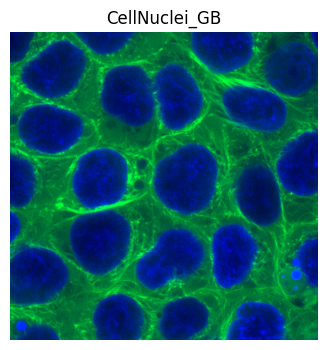

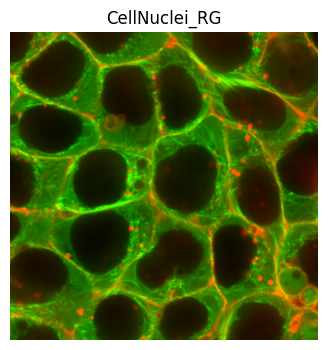

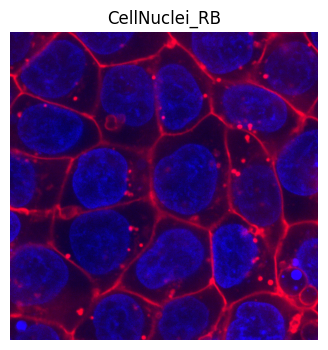

In [65]:
gb_CellNuclei = remove_channel(CellNuclei, channel = "red")

rg_CellNuclei = remove_channel(CellNuclei, channel = "blue")

rb_CellNuclei = remove_channel(CellNuclei, channel = "green")

# Display the modified images

display_images(gb_CellNuclei, "CellNuclei_GB")

display_images(rg_CellNuclei, "CellNuclei_RG")

display_images(rb_CellNuclei, "CellNuclei_RB")

               

# 4. Data Normalization  
## 4.1 Min-Max_Normalization to [0,1] range

Normalizing RGB images to the range 0–1 by dividing pixel values by 255 is useful because it brings all pixel intensities to a common scale. This makes the data easier to work with for many algorithms, especially in machine learning, where models often perform better and converge faster with normalized input. It also helps avoid numerical instability in calculations and ensures consistency across different images

### 4.1.1 Normalize Yeast Cells (by 255)

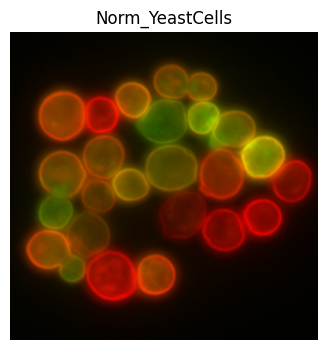

[[[0.00784314 0.00784314 0.        ]
  [0.00784314 0.00784314 0.        ]
  [0.01960784 0.00392157 0.        ]
  ...
  [0.         0.01568628 0.        ]
  [0.         0.00784314 0.        ]
  [0.00392157 0.00784314 0.        ]]]


In [66]:
norm_255_YeastCells = norm_255(YeastCells)

display_images(norm_255_YeastCells, "Norm_YeastCells")

print(norm_255_YeastCells[:1])



In [67]:
# save_image(norm_255_YeastCells, "255_Norm_YeastCells", ext= "jpg")

### 4.1.2 Normalize Cell Nuclei (by 255)

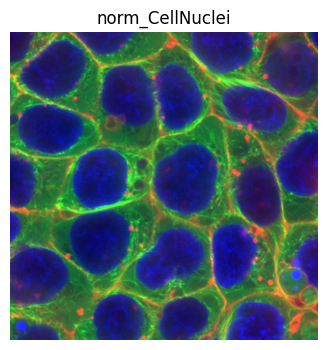

[[[0.14117648 0.05490196 0.5058824 ]
  [0.14901961 0.03529412 0.40392157]
  [0.14117648 0.02352941 0.63529414]
  ...
  [0.09411765 0.05098039 0.69411767]
  [0.13333334 0.04705882 0.83137256]
  [0.0627451  0.0627451  0.62352943]]]


In [68]:
norm_255_CellNuclei = norm_255(CellNuclei)

display_images(norm_255_CellNuclei, "norm_CellNuclei")

print(norm_255_CellNuclei[:1])

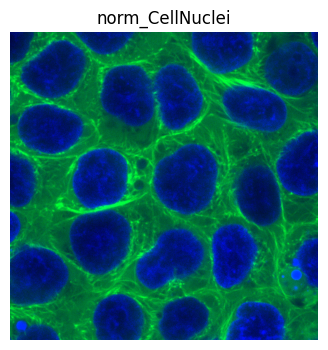

[[[0.14117648 0.05490196 0.5058824 ]
  [0.14901961 0.03529412 0.40392157]
  [0.14117648 0.02352941 0.63529414]
  ...
  [0.09411765 0.05098039 0.69411767]
  [0.13333334 0.04705882 0.83137256]
  [0.0627451  0.0627451  0.62352943]]]


In [69]:
norm_255_gb_CellNuclei = norm_255(gb_CellNuclei)

display_images(norm_255_gb_CellNuclei, "norm_CellNuclei")

print(norm_255_CellNuclei[:1])

save_image(norm_255_gb_CellNuclei, "255_Norm_gb_CellNuclei", ext= "jpg")

In [70]:
# save_image(norm_255_CellNuclei, "255_Norm_CellNuclei", ext= "jpg")

## 4.2 z-transformation 

The z-transformation (also called standardization) is useful for k-means clustering because it centers the data around 0 and scales it to have unit variance. This means all features contribute equally to the distance calculations used by k-means. Without standardization, features with larger ranges could dominate the clustering result, leading to biased or misleading clusters. Z-transformation ensures fair and balanced clustering based on the true structure of the data.

### 4.2.1 Yeast Cells z-transformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0470793..7.571227].


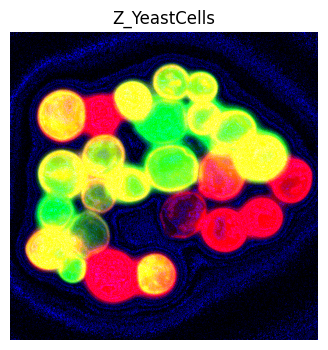

[[[-1.0125939  -0.79698354 -0.47511855]
  [-1.0125939  -0.79698354 -0.47511855]
  [-0.96086574 -0.82561034 -0.47511855]
  ...
  [-1.0470793  -0.73972994 -0.47511855]
  [-1.0470793  -0.79698354 -0.47511855]
  [-1.0298365  -0.79698354 -0.47511855]]]


In [71]:


# 1) Z-Transformierte Version erzeugen
z_YeastCells = z_normalize(YeastCells)

# 2) Anzeige (obwohl visuell unsinnig, werden Werte außerhalb [0,1] abgeschnitten)
display_images(z_YeastCells, "Z_YeastCells")

#3 Display z-transformed array
print(z_YeastCells[:1])


In [72]:
# save_as_numpy(z_YeastCells, "Z_YeastCells")

#### 4.2.2.1 Apply Gauß-Filter to z-transformed Numpy Array of Yeast Cells

In [73]:
z_normalized_gauß = apply_gaussian_to_array(z_YeastCells, kernel_size=5)

# save_as_numpy(z_normalized_gauß, "Z_gaus_YeastCells")


### 4.2.2 Cell Nuclei z-transformation

#### 4.2.2.1 Apply z-transformation to RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2284083..5.1361094].


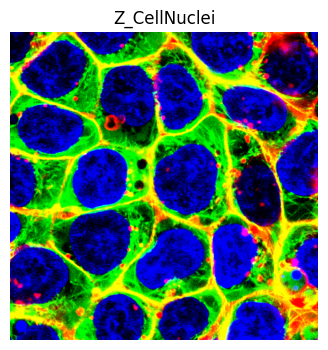

[[[-1.0125939  -0.79698354 -0.47511855]
  [-1.0125939  -0.79698354 -0.47511855]
  [-0.96086574 -0.82561034 -0.47511855]
  ...
  [-1.0470793  -0.73972994 -0.47511855]
  [-1.0470793  -0.79698354 -0.47511855]
  [-1.0298365  -0.79698354 -0.47511855]]]


In [74]:
# 1) Z-Transformierte Version erzeugen
z_CellNuclei = z_normalize(CellNuclei)

# 2) Anzeige (obwohl visuell unsinnig, werden Werte außerhalb [0,1] abgeschnitten)
display_images(z_CellNuclei, "Z_CellNuclei")

#3 Display z-transformed array
print(z_YeastCells[:1])

In [75]:
# save_as_numpy(z_CellNuclei, "Z_CellNuclei")

#### 4.2.2.2 Apply z-transformation to GB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2284083..4.136845].


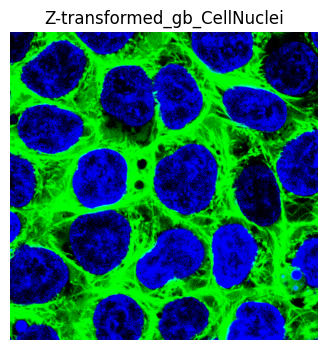

[[[ 0.         -1.2497042   0.9916611 ]
  [ 0.         -1.3457048   0.34265482]
  [ 0.         -1.403305    1.8153998 ]
  ...
  [ 0.         -1.2689043   2.1898265 ]
  [ 0.         -1.2881044   3.0634887 ]
  [ 0.         -1.2113041   1.7405144 ]]]


In [76]:
# 1) Z-Transformierte Version erzeugen
z_gb_CellNuclei = z_normalize(gb_CellNuclei)

# 2) Anzeige (obwohl visuell unsinnig, werden Werte außerhalb [0,1] abgeschnitten)
display_images(z_gb_CellNuclei, "Z-transformed_gb_CellNuclei")

#3 Display z-transformed array
print(z_gb_CellNuclei[:1])

In [77]:
# save_as_numpy(z_gb_CellNuclei, "Z_gb_CellNuclei")

# 5. Final Decision 
Here we collect the most important combinations of the best filters and color models and prepare them for k-means clustering
## 5.1 Apply Bilateral Filter to  normalized GB_CellNuclei
Result is a bilateral filtered normalized CellNuclei image with the red channel set to zero

In [78]:
bilateral_norm_255_gb_CellNuclei = apply_bilateral_to_string(norm_255_gb_CellNuclei, kernel_size=5)

#save_image(bilateral_norm_255_gb_CellNuclei, "GB_bilateral_Norm_255_CellNuclei", ext="tiff")


## 5.2 HSV Hue CellNuclei Image
### 5.2.1 Extract The Hue channel from the Image
The HSV Image is already "normalized" to values between [0,1]

(1024, 1024)
[[0.27058825 0.3019608  0.27058825 ... 0.23137255 0.23921569 0.21176471]
 [0.3254902  0.30980393 0.3019608  ... 0.25882354 0.2509804  0.22352941]
 [0.27058825 0.2784314  0.25882354 ... 0.23137255 0.2509804  0.2509804 ]
 ...
 [0.14901961 0.13725491 0.15686275 ... 0.23921569 0.1254902  0.21176471]
 [0.17254902 0.14509805 0.1254902  ... 0.21176471 0.18039216 0.29411766]
 [0.18039216 0.14901961 0.14509805 ... 0.1882353  0.3254902  0.22352941]]
-Data to importet HSV Image
Shape: (1024, 1024, 4)
Datentyp: float32
Min-Wert: 0.003921569
Max-Wert: 1.0


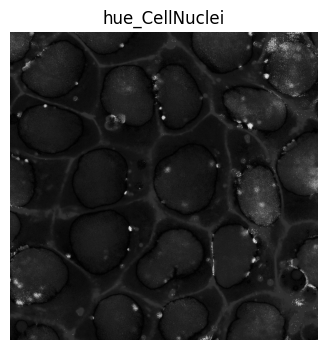

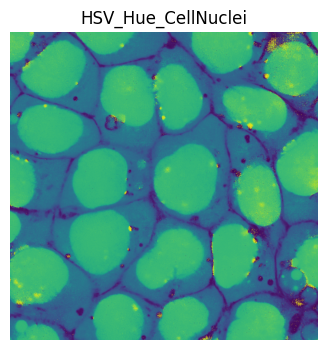

In [79]:
HSV_Hue_CellNuclei = plt.imread("Images/Datenvorbereitung_Images/CellNuclei/HSV_CellNuclei/HSV_CellNuclei_Hue.tiff")

hue_CellNuclei = HSV_Hue_CellNuclei[:, :, 0]

print(hue_CellNuclei.shape)  
print(hue_CellNuclei)

print ("-Data to importet HSV Image")
print("Shape:", HSV_Hue_CellNuclei.shape)
print("Datentyp:", HSV_Hue_CellNuclei.dtype)
print("Min-Wert:", np.min(HSV_Hue_CellNuclei))
print("Max-Wert:", np.max(HSV_Hue_CellNuclei))

display_images_grey(hue_CellNuclei, "hue_CellNuclei")
display_images(HSV_Hue_CellNuclei, "HSV_Hue_CellNuclei")



### 5.2.2 Apply bilateral filter to Hue Channel

In [80]:
hue_bilateral_CellNuclei = apply_bilateral_to_string(hue_CellNuclei, kernel_size=5)

print(hue_bilateral_CellNuclei)

#save_as_numpy(hue_bilateral_CellNuclei, "hue_norm_bilateral_CellNuclei")

[[0.29592916 0.30015078 0.28687933 ... 0.2401218  0.2401204  0.23891336]
 [0.29653087 0.2901964  0.29622826 ... 0.2434394  0.24223201 0.24223185]
 [0.28506884 0.29441792 0.2826548  ... 0.24494794 0.24555045 0.23921648]
 ...
 [0.14871748 0.14419307 0.13393697 ... 0.22926135 0.20542723 0.18974288]
 [0.1487188  0.14660686 0.13785823 ... 0.25460473 0.2539903  0.22503754]
 [0.15324377 0.14781356 0.1414771  ... 0.31342146 0.22292815 0.22956634]]


# 5.3 HSV Hue Yeast Cell Image

(1200, 1200)
[[0.26666668 0.26666668 0.27450982 ... 0.1882353  0.1882353  0.22745098]
 [0.22745098 0.22745098 0.2784314  ... 0.21568628 0.26666668 0.26666668]
 [0.2        0.23529412 0.26666668 ... 0.17254902 0.21568628 0.21568628]
 ...
 [0.27450982 0.2784314  0.23529412 ... 0.22745098 0.21568628 0.21568628]
 [0.26666668 0.26666668 0.22745098 ... 0.21568628 0.21568628 0.21568628]
 [0.1882353  0.26666668 0.22745098 ... 0.21568628 0.21568628 0.2       ]]
-Data to importet HSV Image
Shape: (1200, 1200, 4)
Datentyp: float32
Min-Wert: 0.003921569
Max-Wert: 1.0


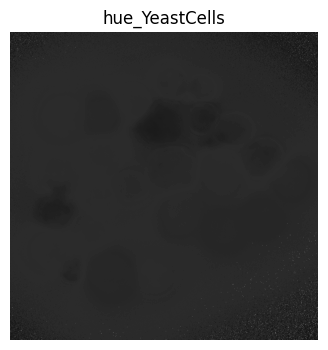

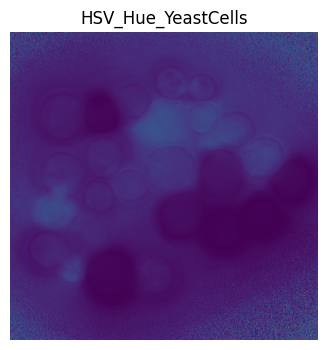

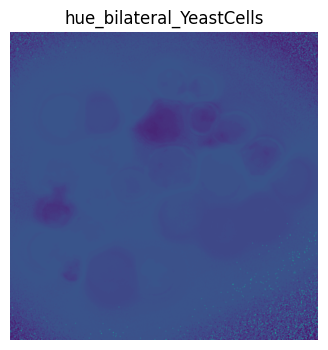

[[0.23951805 0.25339365 0.2666671  ... 0.2051287  0.22383216 0.23167568]
 [0.24132656 0.24464612 0.26214242 ... 0.21055682 0.22262438 0.23046812]
 [0.22986211 0.2380078  0.25369558 ... 0.21478005 0.21930687 0.22443604]
 ...
 [0.25973096 0.2594274  0.24796346 ... 0.22051235 0.21659133 0.21628949]
 [0.25822046 0.25218692 0.24343887 ... 0.21176472 0.21538459 0.21447949]
 [0.2558066  0.2509795  0.23710477 ... 0.21146242 0.20965375 0.21447939]]


In [81]:

HSV_Hue_YeastCells = plt.imread("Images/Datenvorbereitung_Images/YeastCells/HSV_Yeast/HSV_YeastCells_Hue.png")

hue_YeastCells = HSV_Hue_YeastCells[:, :, 0]

print(hue_YeastCells.shape)  
print(hue_YeastCells)

print ("-Data to importet HSV Image")
print("Shape:", HSV_Hue_YeastCells.shape)
print("Datentyp:", HSV_Hue_YeastCells.dtype)
print("Min-Wert:", np.min(HSV_Hue_YeastCells))
print("Max-Wert:", np.max(HSV_Hue_YeastCells))

display_images_grey(hue_YeastCells, "hue_YeastCells")
display_images(HSV_Hue_YeastCells, "HSV_Hue_YeastCells")


hue_bilateral_YeastCells = apply_bilateral_to_string(hue_YeastCells, kernel_size=5)
display_images(hue_bilateral_YeastCells, "hue_bilateral_YeastCells")

print(hue_bilateral_YeastCells)

#save_images(hue_bilateral_YeastCells, "hue_norm_bilateral_YeastCells")


# 5.4 HSV Hue Yeast Cell Image

(1200, 1200)
[[0.34117648 0.34117648 0.35686275 ... 0.3529412  0.34117648 0.34117648]
 [0.3529412  0.3529412  0.34509805 ... 0.3529412  0.33333334 0.33333334]
 [0.36078432 0.35686275 0.34509805 ... 0.35686275 0.34509805 0.34509805]
 ...
 [0.35686275 0.34509805 0.35686275 ... 0.3529412  0.3529412  0.34509805]
 [0.32941177 0.33333334 0.3529412  ... 0.3529412  0.3529412  0.3529412 ]
 [0.34117648 0.33333334 0.3529412  ... 0.3529412  0.3529412  0.36078432]]
- Data to imported HSV Value Image
Shape: (1200, 1200, 4)
Datentyp: float32
Min-Wert: 0.003921569
Max-Wert: 1.0


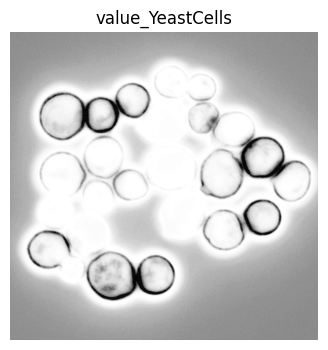

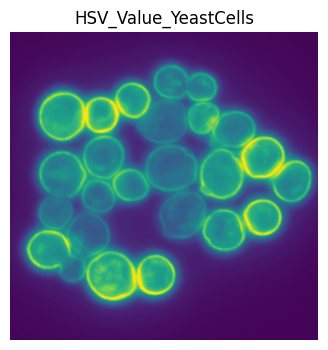

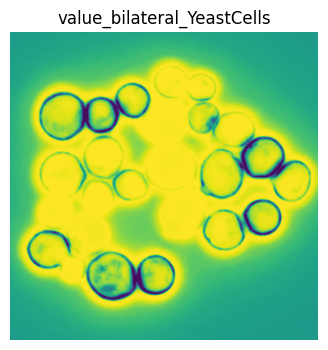

[[0.35203558 0.34901956 0.3453999  ... 0.34992447 0.3432878  0.33996928]
 [0.3508296  0.35082945 0.34841627 ... 0.34962305 0.34449455 0.34238255]
 [0.35445002 0.35384625 0.35082945 ... 0.3502265  0.34781283 0.3466059 ]
 ...
 [0.34479597 0.3469079  0.351433   ... 0.34902003 0.3517344  0.35113108]
 [0.34057283 0.34389126 0.3493214  ... 0.35294116 0.35233793 0.3529412 ]
 [0.33996877 0.34147778 0.3493211  ... 0.35354438 0.35354453 0.3523382 ]]
Shape: (1200, 1200)


In [82]:
# Bild laden
HSV_Value_YeastCells = plt.imread("Images/Datenvorbereitung_Images/YeastCells/HSV_Yeast/HSV_YeastCells_Value.png")

# Value-Kanal extrahieren (Kanal 2 bei HSV als RGB gespeichert)
value_YeastCells = HSV_Value_YeastCells[:, :, 2]

# Ausgabe
print(value_YeastCells.shape)  
print(value_YeastCells)

print("- Data to imported HSV Value Image")
print("Shape:", HSV_Value_YeastCells.shape)
print("Datentyp:", HSV_Value_YeastCells.dtype)
print("Min-Wert:", np.min(HSV_Value_YeastCells))
print("Max-Wert:", np.max(HSV_Value_YeastCells))

# Darstellung (wenn display_images_grey() vorhanden ist)
display_images_grey(value_YeastCells, "value_YeastCells")
display_images(HSV_Value_YeastCells, "HSV_Value_YeastCells")

# Bilateraler Filter anwenden
value_bilateral_YeastCells = apply_bilateral_to_string(value_YeastCells, kernel_size=5)
display_images(value_bilateral_YeastCells, "value_bilateral_YeastCells")

print(value_bilateral_YeastCells)

print("Shape:", value_bilateral_YeastCells.shape)

# Optional speichern
#save_as_numpy(value_bilateral_YeastCells, "value_norm_bilateral_YeastCells")


# 6. Watershed Segmentation (Scikit) of YeastCells

As we have clustered our image with a custom k-means algorithm, we want to segment the individual YeastCells.
CV2 Watershed segmentation didnt generate a saticfactory segmentation, therefore we use scikit to segment the clustered image.
Here we implemented a versions of watershed code to see if it works better.

## 6.1 Watershed No. 1

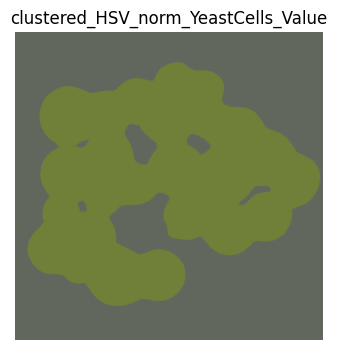

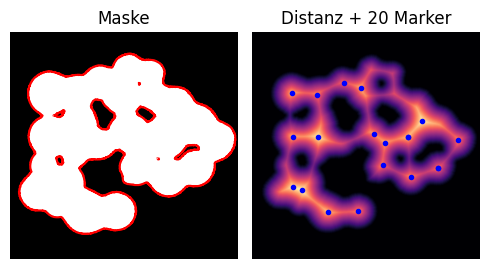

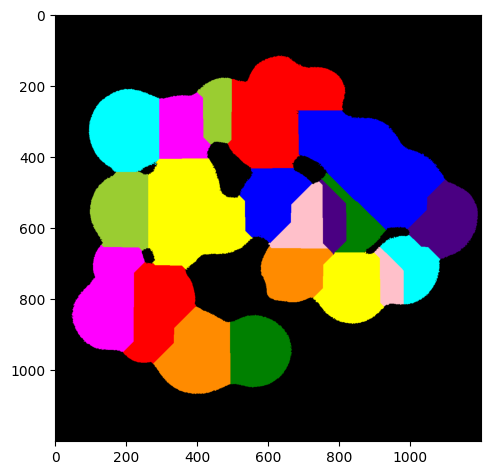

Anzahl der segmentierten Zellen: 20


In [83]:
clustered_HSV_norm_YeastCells_Value = np.copy(plt.imread('Images/Segmented_Images/SegIntoTwoClusters/HSV_segmented_images/clustered_HSV_norm_YeastCells_Value.png')) 

display_images(clustered_HSV_norm_YeastCells_Value, "clustered_HSV_norm_YeastCells_Value")

watershed_HSV_norm_YeastCells_Value = apply_watershed(clustered_HSV_norm_YeastCells_Value, 20)



#save_raw_image(watershed_HSV_norm_YeastCells_Value, "watershed_HSV_norm_YeastCells_Value", ext="tiff")

# 7. K-means cluestering for different filters
Perform k-means for different filtered yeast cells images.
Later compare the clustered images with dice score which filter works the best 

In [84]:
RGB_YeastCells = np.copy(plt.imread('Original_Images/Clustering/Data/Yeast_Cells.jpg'))
RGB_gaus_YeastCells = np.copy(plt.imread("Images/Datenvorbereitung_Images/YeastCells/Filtered_Yeast/Gauß_YeastCells.jpg"))
RGB_bilateral_YeastCells = np.copy(plt.imread("Images/Datenvorbereitung_Images/YeastCells/Filtered_Yeast/Bilateral_YeastCells.jpg"))

centroids_RGB_YeastCells, labels_RGB_YeastCells, clustered_RGB_YeastCells = kmeans(RGB_YeastCells, k=2, init_method='kmeans++', space='rgb')
centroids_RGB_gaus_YeastCells, labels_RGB_gaus_YeastCells, clustered_RGB_gaus_YeastCells = kmeans(RGB_gaus_YeastCells, k=2, init_method='kmeans++', space='rgb')
centroids_RGB_bilateral_YeastCells, labels_RGB_bilateral_YeastCells, clustered_RGB_bilateral_YeastCells = kmeans(RGB_bilateral_YeastCells, k=2, init_method='kmeans++', space='rgb')

#save_image(clustered_RGB_YeastCells, "clustered_YeastCells", ext= "jpg")
#save_image(clustered_RGB_gaus_YeastCells, "clustered_gaussian_YeastCells", ext= "jpg")
#save_image(clustered_RGB_bilateral_YeastCells, "clustered_bilateral_YeastCells", ext= "jpg")